##Writeup Template
###You can use this file as a template for your writeup if you want to submit it as a markdown file, but feel free to use some other method and submit a pdf if you prefer.

---

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

[//]: # (Image References)
[image1]: ./output_images/car_notcar.png
[image2]: ./output_images/HOG_example.png
[image3]: ./output_images/normalized_features.png
[image4]: ./output_images/SVM_accuracy.png
[image5]: ./output_images/heatmap_example.png
[image6]: ./output_images/pipeline_output.png
[image7]: ./output_images/pipeline_output_2.png
[video1]: ./project_video.mp4

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

The entire project code can be found in the jupyter notebook called `Vehicle-Detection-and-Tracking`.

---

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.


The code for this step is contained in the code cells called `Read images`, `Helperfunctions` and `Feature extraction`.

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![alt text][image1]


I then explored different color spaces and different  parameters `orientations`, `pixels_per_cell`, and `cells_per_block` using a Trial and Error approach.  Here is a plot of the HOG-output from the example images above using my final parameter set
.
![alt text][image2]

The `extract_features` function in the `helperfunctions` segment performs the work necessary.
#### 2. Explain how you settled on your final choice of HOG parameters.

I ended up using the parameters that can be found in code cell `Set of Parameters`. The rgb color space didn't perform very well, so I tried different color spaces that can deal with shadows and white lanes. 

I chose the other parameters to maximize my SVM test accuracy with the goal to get an accuracy greater than 97%. I simply tried different parameter combinations and kept track of the Classifier performance. (`orientations=9`, `pixels_per_cell=8`, and `cells_per_block=2`).

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

This step happens in code cells `Feature extraction`, `Shuffle and split the data` and `Train the classifier`.

To get an idea of the input features and their normalization, I plotted the features and their normalization.

![alt text][image3]

I trained a linear SVM using the `extract_features` function from the `Helperfunctions` section. As it turned out, using HOG-features and Color features led to the best prediction accuracy. Here you can see a summary of the SVM training results:

![alt text][image4]

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

The final pipeline can be found in the segment called `final pipeline`

Cars get smaller towards the horizon, so I decided  to look for larger cars at the bottom of the video. I used 3 scales getting larger from the bottom to the top of the images. I found the scales and corresponding overlaps by looking at the video output with the goal to avoid false positives.


#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on three scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

As I already stated, parameter optimization for the classifer and trying out different feature sets (e.g. only hog features) lead to 99.2% test set performance.
![alt text][image6]
![alt text][image7]


### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video.mp4)


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video in a list called `rectangles`.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

To take into account that my pipeline fails in some cases, I'm keeping track of heatmaps from previous frames using global variables. An averaging process also helps to make the predictions less wobbly.

Here is an example of a heat map image:
![alt text][image5]

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

I mainly followed the lecture but a still had problems adapting the lecture code to my own needs. I spent quite a lot of hours debuggingl, for example I used the extract_features function from a previous lesson (not the latest version) and ran into a lot of problems with incorret list shapes because of that.

In the beginning I faced problems with too wobbly detections, so I had to integrate over a few frames to get rid of that. Even 99.X% classifier accuracy with a lot of frames/second still leads to a lot of failed predictions, which also need to be adressed by the heatmap tresholding process.

Most failed detections are on the left lane, which shoulnd't influence the cars behaviour at all. So while the algorithm has ystart and ystop positions, it needs to include the some sort of treshold in x direction. The parameters are working quite well for this particular video section, but I don't think they would would that well for a different video. A deep leaning approach could be helpful for a generalization of the vehicle detection process.



### Read Images

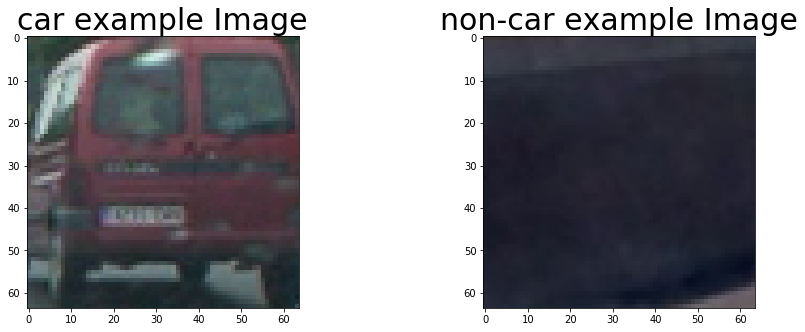

Done


In [1]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

cars = glob.glob('vehicles-2/**/*.png', recursive=True)
non_cars = glob.glob('non-vehicles-2/**/*.png', recursive=True)

vehicles = []
non_vehicles = []

for fname in cars:
    img = mpimg.imread(fname)
    vehicles.append(img) 

for fname in non_cars:
    img = mpimg.imread(fname)
    non_vehicles.append(img) 


vehicles_ind = np.random.randint(0, len(vehicles))
non_vehicles_ind = np.random.randint(0, len(non_vehicles))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.imshow(vehicles[vehicles_ind])
ax1.set_title('car example Image', fontsize=30)
ax2.imshow(non_vehicles[non_vehicles_ind])
ax2.set_title('non-car example Image', fontsize=30)
plt.show()

test_images_fnames = glob.glob('test_images/**/*.jpg', recursive=True)
test_images = []

for fname in test_images_fnames:
    image = mpimg.imread(fname)
    image = image.astype(np.float32)/255
    test_images.append(image)
    
test_image = test_images[3]


print('Done')

### Set of Parameters

In [2]:
color_space = 'YCrCb' # RGB, HSV, LUV, HLS, YUV or YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 700] # Min and max in y to search in slide_window()
transform_sqrt = True # Was True
xy_window = (64, 64)
threshold = 5.0
scale = 1.5
headt_threshold = 5.0 # Threshold to reject false positives
headt_frames = 40


### Helperfunctions

In [3]:

import cv2

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Defines a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img
    
# Defines a function to compute color histogram features  
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    
# Defines a function to return HOG features and visualization    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Defines a function to compute color histogram features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        

# Defines a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

print('done')

done


### Hog example

C:\Users\Tim\Anaconda3\envs\carnd-term1-cpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


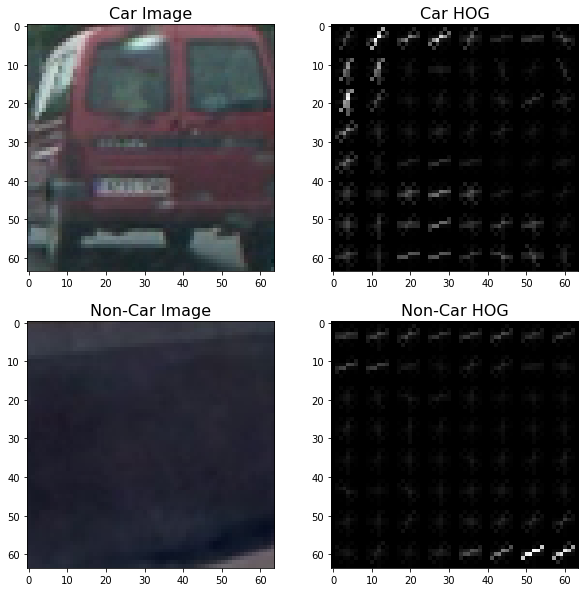

...


In [4]:

_, car_hog = get_hog_features(vehicles[vehicles_ind][:,:,2], orient=orient, pix_per_cell=pix_per_cell,
                           cell_per_block=cell_per_block, vis=True, feature_vec=True)
_, noncar_hog = get_hog_features(non_vehicles[non_vehicles_ind][:,:,2], orient=orient, pix_per_cell=pix_per_cell,
                           cell_per_block=cell_per_block, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.imshow(vehicles[vehicles_ind])
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_hog, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(non_vehicles[non_vehicles_ind])
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_hog, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
plt.show()
print('...')

### Feature extraction

C:\Users\Tim\Anaconda3\envs\carnd-term1-cpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


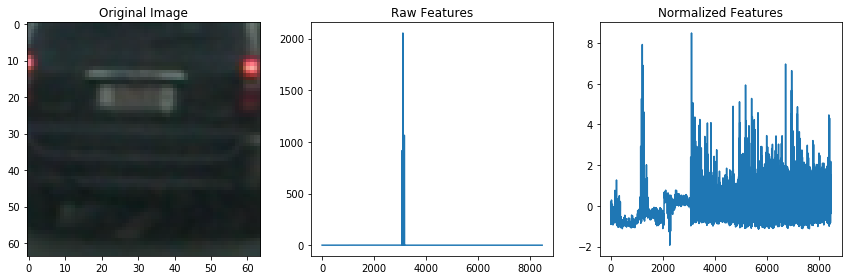

In [5]:
car_features = extract_features(cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(non_cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()
else: 
    print('Your function only returns empty feature vectors...')

### Shuffle and split the data

In [6]:
from sklearn.model_selection import train_test_split
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

### Train the classifier

In [7]:
from sklearn.svm import LinearSVC
import time

# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)
print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 8460
8.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9912
My SVC predicts:  [ 0.  1.  1.  1.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  0.  0.  0.  1.  0.]
0.01151 Seconds to predict 10 labels with SVC


In [8]:
# from sklearn import svm, grid_search, datasets
# parameters = {'kernel':('linear','rbf'), 'C':[1, 10]}
# svr = svm.SVC()
# clf = grid_search.GridSearchCV(svr, parameters)
# clf.fit(X_train, y_train)
# print("Best parameters found:")
# print(clf.best_params_)

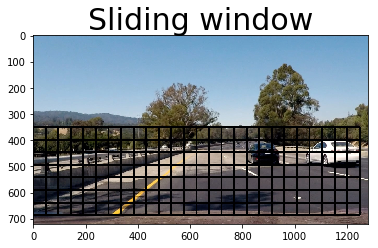

Done


In [9]:
import os

# Defines a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

 
windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.title('Sliding window', fontsize=30)
plt.show()
print('Done')

C:\Users\Tim\Anaconda3\envs\carnd-term1-cpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


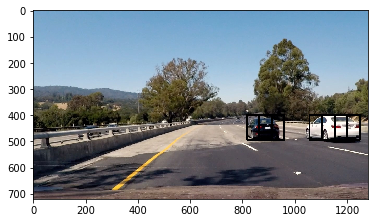

In [10]:
# Defines a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Defines a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        features = np.reshape(features, (1,-1))
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


hot_windows = search_windows(test_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

draw_image = np.copy(test_image)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# fig = plt.figure(figsize=(20, 8))        
# for ind, image_dir in enumerate(images_dir):
#      img = mpimg.imread(os.path.join("test_images", image_dir))
#      fig.add_subplot(1,5,ind+1)
#      plt.imshow(img)
        
plt.imshow(window_img)
plt.show()

C:\Users\Tim\Anaconda3\envs\carnd-term1-cpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


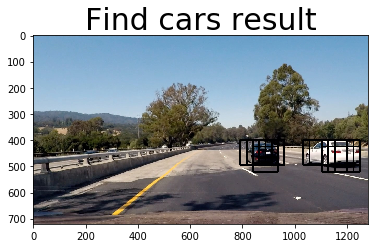

Done


In [11]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.title('Find cars result', fontsize=30)
plt.show()

print('Done')

### Find car rectangles

C:\Users\Tim\Anaconda3\envs\carnd-term1-cpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


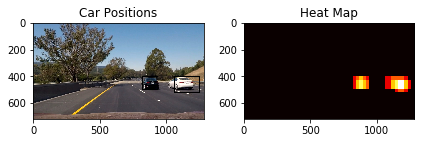

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    rectangles = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

rectangles = find_car_rectangles(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                 cell_per_block, spatial_size, hist_bins)
draw_img = draw_boxes(np.copy(test_image), rectangles, thick=2) 

heat = np.zeros_like(test_image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,rectangles)   
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
from scipy.ndimage.measurements import label
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

In [13]:
# Define a class to store rectangle data from the video
# Class is similar to a class on the forum, but I can't find the exact post.
class RectStorage():
    def __init__(self):
        # list containing the rectangles found in previous frames
        self.prev_rectangles = [] 
        
    def add_rectangles(self, rectangles):
        self.prev_rectangles.append(rectangles)
        if len(self.prev_rectangles) > 15:
            # Delete older rectangles
            self.prev_rectangles = self.prev_rectangles[len(self.prev_rectangles)-15:]

print('Done')

Done


### Final pipeline

In [14]:
def image_pipeline_global(img):
    global heatmaps
    global average_heatmap
    
    rectangles=[]
    
    # Check 3 different sizes, ystart and ystop smaller towards the horizon
    ystart = 350
    ystop = 550
    scale = 1.5
    rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
                                          pix_per_cell, cell_per_block, spatial_size, hist_bins))
        
    ystart = 350
    ystop = 600
    scale = 2.0
    rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
                                          pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 500
    ystop = 700
    scale = 2.5
    rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
                                          pix_per_cell, cell_per_block, spatial_size, hist_bins))

    
    #Flatten the nested list
    rectangles = [item for sublist in rectangles  for item in sublist]
    
    try:
        n = 15
        # Add flattened rectangle list to the averaging process
        if len(rectangles) > 0:
            heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
            # Add heat to each box in box list
            heat = add_heat(heat,rectangles)
            if(len(heatmaps) < n):
                heatmaps.append(heat)
                avg_heatmap = sum(heatmaps)/len(heatmaps)
            else:
                heatmaps.pop(0)
                heatmaps.append(heat)
                avg_heatmap = sum(heatmaps)/len(heatmaps)
            average_heatmap = avg_heatmap
            heat = avg_heatmap
        else:
            heat = average_heatmap


        # Apply threshold to help remove false positives    
        heat = apply_threshold(heat, 1)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)

        return draw_img
    except:
        return img

    

C:\Users\Tim\Anaconda3\envs\carnd-term1-cpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


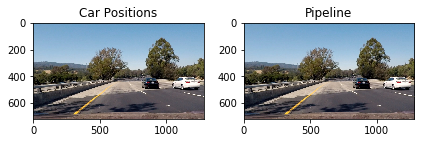

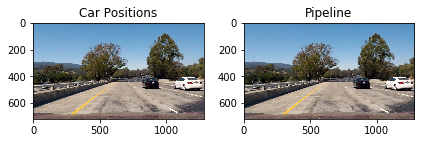

In [15]:
draw_image = image_pipeline_global(test_image)
test_image2 = test_images[0]
draw_image2 = image_pipeline_global(test_image2)

fig = plt.figure()
plt.subplot(121)
plt.imshow(test_image)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(draw_image, cmap='hot')
plt.title('Pipeline')
fig.tight_layout()
plt.show()
fig = plt.figure()
plt.subplot(121)
plt.imshow(test_image2)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(draw_image2, cmap='hot')
plt.title('Pipeline')
fig.tight_layout()
plt.show()

In [16]:
# def image_pipeline_storage(img):
    
#     rectangles=[]
    
#     #Check 3 different sizes, ystart and ystop smaller towards the horizon
#     ystart = 350
#     ystop = 550
#     scale = 1.5
#     rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
#                                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
        
#     ystart = 350
#     ystop = 600
#     scale = 2.0
#     rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
#                                           pix_per_cell, cell_per_block, spatial_size, hist_bins))

#     ystart = 500
#     ystop = 700
#     scale = 2.5
#     rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
#                                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     ystart = 400
#     ystop = 464
#     scale = 1.0
#     rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
#                                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
        
#     ystart = 416
#     ystop = 480
#     scale = 1.0
#     rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
#                                           pix_per_cell, cell_per_block, spatial_size, hist_bins))

#     ystart = 400
#     ystop = 496
#     scale = 1.5
#     rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
#                                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
#     ystart = 432
#     ystop = 528
#     scale = 1.5
#     rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
#                                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
        
#     ystart = 400
#     ystop = 528
#     scale = 2.0
#     rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
#                                           pix_per_cell, cell_per_block, spatial_size, hist_bins))

#     ystart = 432
#     ystop = 560
#     scale = 2.0
#     rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
#                                           pix_per_cell, cell_per_block, spatial_size, hist_bins))

    
#     ystart = 400
#     ystop = 596
#     scale = 3.5
#     rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
#                                           pix_per_cell, cell_per_block, spatial_size, hist_bins))

#     ystart = 464
#     ystop = 660
#     scale = 3.5
#     rectangles.append(find_car_rectangles(img, ystart, ystop, scale, svc, X_scaler, orient,
#                                           pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
#     #Flatten the nested list
#     rectangles = [item for sublist in rectangles  for item in sublist]
    
#     # Add flattened rectangle list to the averaging process
#     if len(rectangles) > 0:
#         storage.add_rectangles(rectangles)
        
#     heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
    
#     for rects in storage.prev_rectangles:
#         # Add heat to each box in box list
#         heat = add_heat(heat,rectangles)
        
#     # Apply threshold to help remove false positives    
#     heat = apply_threshold(heat, 8 + len(storage.prev_rectangles)//2)
#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat, 0, 255)
    
#     labels = label(heatmap)
#     draw_img = draw_labeled_bboxes(np.copy(img), labels)

#     return draw_img

In [17]:
heatmaps = []

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_output.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(22,32)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(image_pipeline_global) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [16:38<00:00,  1.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 16min 39s


In [18]:
# storage = RectStorage()
# # Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

# output = 'project_video_output.mp4'
# #clip1 = VideoFileClip("project_video.mp4").subclip(20,25)
# clip1 = VideoFileClip("project_video.mp4")
# white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(output, audio=False)